#### Problem Statement
##### Purpose of this project:
- Train Denoising Autoencoders using Pytorch Framework.
- Train Self-supervised Autoencoders from the learnt latent representation.

In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


## Denoising Autoencoder

In [20]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

transforms=transforms.ToTensor()

train_data=datasets.MNIST('data',train=True,download=True,transform=transforms)
test_data=datasets.MNIST('data',train=False,download=True,transform=transforms)

BATCH_SIZE = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

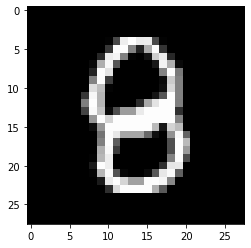

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[19])

fig = plt.figure(figsize = (4,4)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

Add noise to input images

In [24]:
# for adding noise to images
noise_factor = 0.5

def noisy_images(images, noise_factor):
    noisy = images + torch.randn_like(images) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

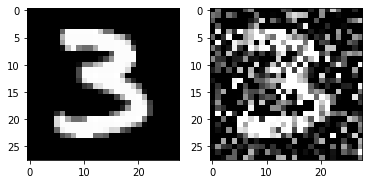

In [25]:
dataiter = iter(train_loader)
images, labels = dataiter.next()


noisy_images = noisy_images(images, noise_factor)
noisy_img = np.squeeze(noisy_images[19])
raw_img = np.squeeze(images[19])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(raw_img, cmap='gray')
axarr[1].imshow(noisy_img, cmap='gray')


In [30]:
def noisy_images(images, noise_factor):
    noisy = images + torch.randn_like(images) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class ConvDenoiser(nn.Module):
    def __init__(self):        
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 4, 5, padding=1),
            nn.BatchNorm2d(4),
            nn.MaxPool2d((2,2)),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16,7, stride = 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d((2,2)),
            nn.ConvTranspose2d(16, 1, 14, stride=2),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# initialize the NN
model = ConvDenoiser()

summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5            [-1, 4, 12, 12]           1,604
       BatchNorm2d-6            [-1, 4, 12, 12]               8
         MaxPool2d-7              [-1, 4, 6, 6]               0
   ConvTranspose2d-8           [-1, 16, 17, 17]           3,152
              ReLU-9           [-1, 16, 17, 17]               0
      BatchNorm2d-10           [-1, 16, 17, 17]              32
        MaxPool2d-11             [-1, 16, 8, 8]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]           3,137
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 8,125
Trainable params: 8

In [32]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# number of epochs to train the model
n_epochs = 20
outputs = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images, _ = data
#         images = images.numpy()
        image_noisy = noisy_images(images, noise_factor)

        recon = model(image_noisy)
        loss = criterion(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    outputs.append((epoch, image_noisy, recon, images))
    

Epoch: 1 	Training Loss: 0.028212
Epoch: 2 	Training Loss: 0.020856
Epoch: 3 	Training Loss: 0.019752
Epoch: 4 	Training Loss: 0.019224
Epoch: 5 	Training Loss: 0.018863
Epoch: 6 	Training Loss: 0.018632
Epoch: 7 	Training Loss: 0.018478
Epoch: 8 	Training Loss: 0.018346
Epoch: 9 	Training Loss: 0.018212
Epoch: 10 	Training Loss: 0.018077
Epoch: 11 	Training Loss: 0.018011
Epoch: 12 	Training Loss: 0.017925
Epoch: 13 	Training Loss: 0.017823
Epoch: 14 	Training Loss: 0.017792
Epoch: 15 	Training Loss: 0.017718
Epoch: 16 	Training Loss: 0.017684
Epoch: 17 	Training Loss: 0.017621
Epoch: 18 	Training Loss: 0.017602
Epoch: 19 	Training Loss: 0.017549
Epoch: 20 	Training Loss: 0.017528


##### Train Data and Results Visualization

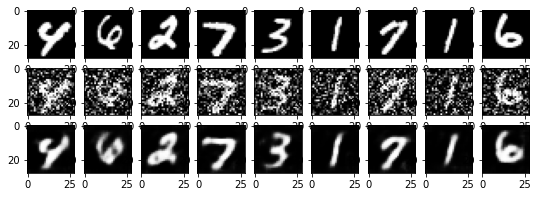

In [75]:
import matplotlib.pyplot as plt
for k in range(0, 3, 4):
    plt.figure(figsize=(9, 3))
    plt.gray()
    raw_imgs = outputs[k][3].detach().numpy()
    noisy_imgs = outputs[k][1].detach().numpy()
    recon_imgs = outputs[k][2].detach().numpy()
    for i, item in enumerate(raw_imgs):
        if i >= 9: break
        plt.subplot(3, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(noisy_imgs):
        if i >= 9: break
        plt.subplot(3, 9, 9+i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon_imgs):
        if i >= 9: break
        plt.subplot(3, 9, 18+i+1) # row_length + i + 1
        plt.imshow(item[0])

Show your model outputs along with the noisy images in a single plot (use subplots).

##### Test data and Results Vizualization

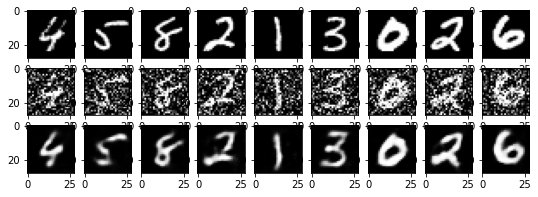

In [101]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_images = noisy_images(images, noise_factor)
model.eval()
# get sample outputs
outputs = model(noisy_images)
loss = criterion(images, outputs)

# plot the images
import matplotlib.pyplot as plt
for k in range(0, 3, 4):
    plt.figure(figsize=(9, 3))
    plt.gray()
    raw_imgs = images
    noisy_imgs = noisy_images
    recon_imgs = outputs.detach().numpy()
    for i, item in enumerate(raw_imgs):
        if i >= 9: break
        plt.subplot(3, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(noisy_imgs):
        if i >= 9: break
        plt.subplot(3, 9, 9+i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon_imgs):
        if i >= 9: break
        plt.subplot(3, 9, 18+i+1) # row_length + i + 1
        plt.imshow(item[0])

## Self-Supervised Learning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
import torch.optim
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import random

from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

#### Handwritten MNIST Dataset

In [3]:
transforms=transforms.ToTensor()

train_data = datasets.MNIST('data',train=True,download=True,transform=transforms)
test_data  = datasets.MNIST('data',train=False,download=True,transform=transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 20, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size = 20, shuffle = True)

#### Dataloaders for labeled, unlabeled and validation set

In [4]:
valid_size  = 0.1
batch_size  = 20
num_workers = 0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)

split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
unlabeled_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

labeled_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

print ('size of unlabeled data  = ', 20 * len(unlabeled_loader))
print ('size of labeled data    = ', 20 * len(valid_loader))
print ('size of validation data = ', 20 * len(labeled_loader))

size of unlabeled data  =  54000
size of labeled data    =  6000
size of validation data =  10000


#### Visualize Dataset

In [5]:
# checking our data
dataiter = iter(train_loader)
images , labels = dataiter.next()
print(labels,labels.shape,len(labels))

tensor([6, 6, 7, 3, 4, 0, 6, 2, 4, 8, 6, 6, 3, 8, 6, 7, 4, 2, 5, 5]) torch.Size([20]) 20


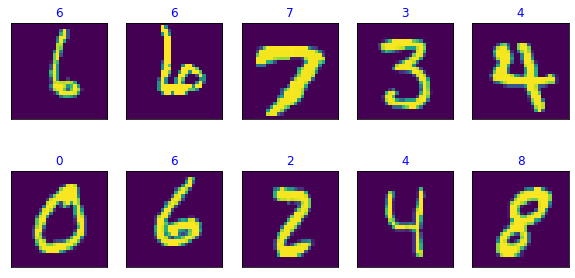

In [6]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(10,5))
for i in range(len(labels)-10):
    ax=fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

#### Supervised Learning

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Flatten(start_dim=1),
                                nn.Linear(784, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.5),
                                nn.Linear(128, 64),
                                nn.BatchNorm1d(64),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.5),
                                nn.Linear(64, 10))
        
    def forward(self,x):
        x=self.fc(x)
        return x

net = Net()

summary(net, (28,28,1))

GPU = torch.cuda.is_available()
if GPU:
    net = net.cuda()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated T

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 20

use_cuda = True

for epoch in range(epochs):
    total = 0
    correct = 0
    
    net.train()
    for data in labeled_loader:
        image, label = data
        optimizer.zero_grad()
        output = net(image)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for data in valid_loader:
            image, label = data
            output = net(image)
            for idx, i in enumerate(output):
                if torch.argmax(i) == label[idx]:
                    correct +=1
                total +=1

    print(f'Epoch : {epoch + 1}/{epochs} \tValidation Accuracy : {round(correct/total, 3)*100} %')

Epoch : 1/20 	Validation Accuracy : 77.4 %
Epoch : 2/20 	Validation Accuracy : 81.5 %
Epoch : 3/20 	Validation Accuracy : 81.69999999999999 %
Epoch : 4/20 	Validation Accuracy : 83.39999999999999 %
Epoch : 5/20 	Validation Accuracy : 84.0 %
Epoch : 6/20 	Validation Accuracy : 84.39999999999999 %
Epoch : 7/20 	Validation Accuracy : 84.8 %
Epoch : 8/20 	Validation Accuracy : 84.39999999999999 %
Epoch : 9/20 	Validation Accuracy : 85.2 %
Epoch : 10/20 	Validation Accuracy : 86.3 %
Epoch : 11/20 	Validation Accuracy : 85.9 %
Epoch : 12/20 	Validation Accuracy : 84.8 %
Epoch : 13/20 	Validation Accuracy : 86.1 %
Epoch : 14/20 	Validation Accuracy : 86.0 %
Epoch : 15/20 	Validation Accuracy : 86.3 %
Epoch : 16/20 	Validation Accuracy : 86.4 %
Epoch : 17/20 	Validation Accuracy : 87.1 %
Epoch : 18/20 	Validation Accuracy : 86.2 %
Epoch : 19/20 	Validation Accuracy : 86.3 %
Epoch : 20/20 	Validation Accuracy : 86.8 %


#### Learn Representation using Autoencoder

In [9]:
class AE(nn.Module):
    def __init__(self):        
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 4, 5, padding=1),
            nn.BatchNorm2d(4),
            nn.MaxPool2d((2,2)),
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16,7, stride = 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d((2,2)),
            nn.ConvTranspose2d(16, 1, 14, stride=2),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
model = AE()

use_cuda=True
if use_cuda and torch.cuda.is_available():
    model.cuda()

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5            [-1, 4, 12, 12]           1,604
       BatchNorm2d-6            [-1, 4, 12, 12]               8
         MaxPool2d-7              [-1, 4, 6, 6]               0
   ConvTranspose2d-8           [-1, 16, 17, 17]           3,152
              ReLU-9           [-1, 16, 17, 17]               0
      BatchNorm2d-10           [-1, 16, 17, 17]              32
        MaxPool2d-11             [-1, 16, 8, 8]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]           3,137
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 8,125
Trainable params: 8

In [11]:
criterion = nn.MSELoss()

In [12]:
def train(model, lr):
    optimizer=torch.optim.Adam(model.parameters(), lr = lr)
    loss_keeper={'train':[]}
    epochs=20

    for epoch in range(epochs):
        train_loss=0.0
        model.train()
        
        for images,_ in train_loader:
            'Code here'

            output = model(images)
            loss = criterion(output, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss.item()
            
    # print avg training statistics 
        train_loss = train_loss/len(train_loader)

        # Calculate loss over entire batch size for every epoch

        loss_keeper['train'].append(train_loss)

        print(f"\nEpoch : {epoch + 1}/{epochs}\tTraining Loss : {train_loss}")
    return(loss_keeper)

In [13]:
model_loss = train(model, 0.01)


Epoch : 1/20	Training Loss : 0.022066740442067384

Epoch : 2/20	Training Loss : 0.010507605686783791

Epoch : 3/20	Training Loss : 0.009562900848376254

Epoch : 4/20	Training Loss : 0.009074533496828128

Epoch : 5/20	Training Loss : 0.008842814633622766

Epoch : 6/20	Training Loss : 0.008655777090073874

Epoch : 7/20	Training Loss : 0.00844088252245759

Epoch : 8/20	Training Loss : 0.008390023121765504

Epoch : 9/20	Training Loss : 0.008261774784885347

Epoch : 10/20	Training Loss : 0.008170936048806955

Epoch : 11/20	Training Loss : 0.008102474809934696

Epoch : 12/20	Training Loss : 0.008082492950993279

Epoch : 13/20	Training Loss : 0.008015247499880692

Epoch : 14/20	Training Loss : 0.00792853551528727

Epoch : 15/20	Training Loss : 0.00792548061053579

Epoch : 16/20	Training Loss : 0.007854455636814237

Epoch : 17/20	Training Loss : 0.00781262676914533

Epoch : 18/20	Training Loss : 0.007770653443255772

Epoch : 19/20	Training Loss : 0.007761892677129557

Epoch : 20/20	Training L

In [14]:
#save the encoder to append it with classifier later
torch.save(model.encoder, "encoder.pth")
encode_model = torch.load('encoder.pth')

In [16]:
encode_model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 4, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

#### Self-Supervised Learning

Attach the Classifier module in front of your Encoder 

In [18]:
class classification(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.AE = AE()
        self.encoder=encode_model
        self.classifier = nn.Sequential(nn.Flatten(start_dim=1),
                                nn.Linear(144, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.5),
                                nn.Linear(128, 64),
                                nn.BatchNorm1d(64),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.5),
                                nn.Linear(64, 10))
        ##You can use as many linear layers and other activations as you want
    def forward(self, input):
#         x = self.AE.encode(input)
        x = self.encoder(input)
#         x = model.encoder(input)
        output = self.classifier(x)
        ##You can use a sigmoid or softmax here if neecd
        return output
GPU = torch.cuda.is_available()

classifier_model_obj = classification()
summary(classifier_model_obj, (1,28,28))

if GPU:
    classifier_model_obj  = classifier_model_obj .cuda()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5            [-1, 4, 12, 12]           1,604
       BatchNorm2d-6            [-1, 4, 12, 12]               8
         MaxPool2d-7              [-1, 4, 6, 6]               0
           Flatten-8                  [-1, 144]               0
            Linear-9                  [-1, 128]          18,560
      BatchNorm1d-10                  [-1, 128]             256
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
      BatchNorm1d-14                   

In [19]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_model_obj.parameters(), lr = 0.001)
epochs = 20

for epoch in range(epochs):
    total = 0
    correct = 0
    classifier_model_obj.train()

    for data in labeled_loader:
        image, label = data
        optimizer.zero_grad()
        output = classifier_model_obj(image)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for data in valid_loader:
            image, label = data
            output = classifier_model_obj(image)
            for idx, i in enumerate(output):
                if torch.argmax(i) == label[idx]:
                    correct +=1
                total +=1

    print(f'Epoch : {epoch + 1}/{epochs} \tValidation Accuracy : {round(correct/total, 3)*100} %')

Epoch : 1/20 	Validation Accuracy : 80.0 %
Epoch : 2/20 	Validation Accuracy : 82.69999999999999 %
Epoch : 3/20 	Validation Accuracy : 85.6 %
Epoch : 4/20 	Validation Accuracy : 87.4 %
Epoch : 5/20 	Validation Accuracy : 88.3 %
Epoch : 6/20 	Validation Accuracy : 89.60000000000001 %
Epoch : 7/20 	Validation Accuracy : 89.60000000000001 %
Epoch : 8/20 	Validation Accuracy : 90.0 %
Epoch : 9/20 	Validation Accuracy : 90.7 %
Epoch : 10/20 	Validation Accuracy : 90.7 %
Epoch : 11/20 	Validation Accuracy : 90.9 %
Epoch : 12/20 	Validation Accuracy : 91.2 %
Epoch : 13/20 	Validation Accuracy : 91.2 %
Epoch : 14/20 	Validation Accuracy : 91.9 %
Epoch : 15/20 	Validation Accuracy : 92.30000000000001 %
Epoch : 16/20 	Validation Accuracy : 92.0 %
Epoch : 17/20 	Validation Accuracy : 92.80000000000001 %
Epoch : 18/20 	Validation Accuracy : 92.4 %
Epoch : 19/20 	Validation Accuracy : 92.2 %
Epoch : 20/20 	Validation Accuracy : 92.80000000000001 %


##### Comment : 
After connecting the pretrained encoder with the classifier, we can clearly see that the performance is improved.
    The reason is that the encoder is pretrained on all data i.e., labelled and unlabelled. The encoder had learnt the correct representation of the data. And then it is able to perform better on labelled data only.